In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tqdm import tqdm

import nltk
nltk.download('punkt')

import tensorflow as tf
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2.3.0


In [ ]:
#!touch Dataset.txt

In [ ]:
with open("/content/Dataset.txt") as f:
  Data = f.read()

In [ ]:
Data = Data.lower()

In [ ]:
Data = re.sub(r'[\n]', ' ', Data)
Data = re.sub(r'[\'"?!]', '', Data)
Data = re.sub(r'[.,]', ' ', Data)
Data = re.sub(r'[:;]', ' ', Data)
Data = re.sub(r'[0]', ' ', Data)
Data = re.sub(r'[1]', ' ', Data)
Data = re.sub(r'[\[\]]', ' ', Data)
Data = re.sub(r'[\-]', ' ', Data)

In [ ]:
Data

'i dont think that any of my adventures with mr  sherlock holmes opened quite so abruptly  or so dramatically  as that which i associate with the three gables  i had not seen holmes for some days and had no idea of the new channel into which his activities had been directed  he was in a chatty mood that morning  however  and had just settled me into the well worn low armchair on one side of the fire  while he had curled down with his pipe in his mouth upon the opposite chair  when our visitor arrived  if i had said that a mad bull had arrived it would give a clearer impression of what occurred    the door had flown open and a huge negro had burst into the room  he would have been a comic figure if he had not been terrific  for he was dressed in a very loud gray check suit with a flowing salmon coloured tie  his broad face and flattened nose were thrust forward  as his sullen dark eyes  with a smouldering gleam of malice in them  turned from one of us to the other    which of you genlme

In [ ]:
words = nltk.word_tokenize(Data)

In [ ]:
words

['i',
 'dont',
 'think',
 'that',
 'any',
 'of',
 'my',
 'adventures',
 'with',
 'mr',
 'sherlock',
 'holmes',
 'opened',
 'quite',
 'so',
 'abruptly',
 'or',
 'so',
 'dramatically',
 'as',
 'that',
 'which',
 'i',
 'associate',
 'with',
 'the',
 'three',
 'gables',
 'i',
 'had',
 'not',
 'seen',
 'holmes',
 'for',
 'some',
 'days',
 'and',
 'had',
 'no',
 'idea',
 'of',
 'the',
 'new',
 'channel',
 'into',
 'which',
 'his',
 'activities',
 'had',
 'been',
 'directed',
 'he',
 'was',
 'in',
 'a',
 'chatty',
 'mood',
 'that',
 'morning',
 'however',
 'and',
 'had',
 'just',
 'settled',
 'me',
 'into',
 'the',
 'well',
 'worn',
 'low',
 'armchair',
 'on',
 'one',
 'side',
 'of',
 'the',
 'fire',
 'while',
 'he',
 'had',
 'curled',
 'down',
 'with',
 'his',
 'pipe',
 'in',
 'his',
 'mouth',
 'upon',
 'the',
 'opposite',
 'chair',
 'when',
 'our',
 'visitor',
 'arrived',
 'if',
 'i',
 'had',
 'said',
 'that',
 'a',
 'mad',
 'bull',
 'had',
 'arrived',
 'it',
 'would',
 'give',
 'a',
 'clea

In [ ]:
word_to_index = {}
index_to_word = {}
count = 0
for word in words:
  if(word not in word_to_index.keys()):
    word_to_index[word] = count
    count = count + 1
for word in word_to_index.keys():
  index_to_word[word_to_index[word]] = word

In [ ]:
word_to_index

In [ ]:
index_to_word

In [ ]:
def get_window(words, window_size):
  i = window_size
  while(i < len(words) - window_size):
    centre_word = words[i]
    context_words = words[i - window_size: i] + words[i + 1 : i + 1 + window_size]
    yield centre_word, context_words
    i = i + 1 

In [ ]:
def word_to_one_hot_vector(word, word_to_index):
  one_hot_vector = np.zeros(shape = (len(word_to_index), 1))
  one_hot_vector[word_to_index[word]][0] = 1
  return one_hot_vector

In [ ]:
def context_word_to_vector(context_words, word_to_index):
  context_word_vector = [word_to_one_hot_vector(word, word_to_index) for word in context_words]
  context_word_vector = np.mean(context_word_vector, axis = 0)
  return context_word_vector

In [ ]:
def get_training_example(words, window_size, word_to_index):
  for centre_word, context_words in get_window(words, window_size):
    yield context_word_to_vector(context_words, word_to_index), word_to_one_hot_vector(centre_word, word_to_index) 

In [ ]:
training_examples = get_training_example(words, 8, word_to_index)

In [ ]:
X_train, y_train = next(training_examples)
looping = True
while looping:
  try:
    X, y = next(training_examples)
    X_train = np.concatenate((X_train, X), axis = 1)
    y_train = np.concatenate((y_train, y), axis = 1)
  except StopIteration:
    looping = False

In [ ]:
def Weight_Intialization(V, n_Hidden):
  W1 = np.random.randn(n_Hidden, V)
  b1 = np.random.randn(n_Hidden, 1)
  W2 = np.random.randn(V, n_Hidden)
  b2 = np.random.randn(V, 1)
  return W1, b1, W2, b2

In [ ]:
def relu(z):
  return np.maximum(0, z)

In [ ]:
def softmax(z):
  ex = np.exp(z)
  return ex/np.sum(ex, axis = 0)

In [ ]:
def forward_pass(x, W1, b1, W2, b2):
  Z1 = np.dot(W1, x) + b1
  Z1 = relu(Z1)
  Z2 = np.dot(W2, Z1) + b2
  ypred = softmax(Z2)
  return Z1, Z2, ypred

In [ ]:
def error_calculation(y, ypred, m):
  error = -(np.sum(np.multiply(y, np.log(ypred))))/m
  return error

In [ ]:
def back_prop(W1, b1, W2, b2, Z1, Z2, y, ypred, x):
  dW1 = np.dot(relu(np.dot(W2.T, ypred - y)), x.T)
  db1 = relu(np.dot(W2.T, ypred - y))
  dW2 = np.dot(ypred - y, Z1.T)
  db2 = ypred - y
  return dW1, db1, dW2, db2

In [ ]:
def model(x, y, epoches = 10, learning_rate = 0.01):
  V = x.shape[0]
  m = x.shape[1]
  n_Hidden = 300
  W1, b1, W2, b2 = Weight_Intialization(V, n_Hidden)
  error = []
  for i in tqdm(range(epoches)):
    Z1, Z2, ypred = forward_pass(x, W1, b1, W2, b2)
    error.append(error_calculation(y, ypred, m))
    dW1, db1, dW2, db2 = back_prop(W1, b1, W2, b2, Z1, Z2, y, ypred, x)
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
  return ypred, error, W1, W2

In [ ]:
ypred, error, W1, W2 = model(X_train, y_train, 100)

  1%|          | 1/100 [00:01<02:49,  1.72s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


In [ ]:
ypred

array([[0.00160048, 0.00160191, 0.00160185, ..., 0.001601  , 0.00160267,
        0.00160048],
       [0.00054973, 0.00055021, 0.00055019, ..., 0.00054991, 0.00055048,
        0.00054973],
       [0.00049157, 0.00049201, 0.00049199, ..., 0.00049173, 0.00049225,
        0.00049157],
       ...,
       [0.00044183, 0.00044223, 0.00044221, ..., 0.00044198, 0.00044244,
        0.00044183],
       [0.00038514, 0.00038548, 0.00038547, ..., 0.00038527, 0.00038567,
        0.00038514],
       [0.00205056, 0.00205238, 0.0020523 , ..., 0.00205124, 0.00205337,
        0.00205056]])

In [ ]:
error

[34.63971273688142,
 nan,
 nan,
 nan,
 nan,
 nan,
 7.562030226820257,
 7.551471108502151,
 7.541734116689501,
 7.531965621334133,
 7.5221505827099,
 7.512230195017882,
 7.502302433214189,
 7.492339991903628,
 7.482364070347131,
 7.47238920326625,
 7.462415167618191,
 7.45242464599402,
 7.442422763895874,
 7.432421077929071,
 7.4224195900243,
 7.412418302131318,
 7.402417216218977,
 7.392416334275443,
 7.382415658308424,
 7.3724151903454045,
 7.3624149324336186,
 7.352414886640527,
 7.34241505505377,
 7.332415439781532,
 7.322416042952579,
 7.312416866716648,
 7.302417913244407,
 7.292419184727902,
 7.282420683380564,
 7.272422411437497,
 7.262424371155763,
 7.2524265648143755,
 7.242428994714744,
 7.232431663180709,
 7.222434572558886,
 7.212437725218758,
 7.202441123552992,
 7.192444769977615,
 7.182448666932253,
 7.172452816880325,
 7.1624572223092615,
 7.152461885730796,
 7.142466809681124,
 7.132471996721221,
 7.122477449436877,
 7.112483170439221,
 7.1024891623647575,
 7.092495427

In [ ]:
W1

array([[-1.37472245e+02, -8.31015248e+00, -1.00167644e+01, ...,
        -1.12951568e+00,  4.60692314e-01, -2.84816941e+00],
       [-7.97560778e+01, -9.22382231e+00, -6.69915111e+00, ...,
        -1.41133806e+00, -1.03433904e+00, -2.39482101e-01],
       [-2.08708733e+02, -8.59527680e+00, -1.22520870e+01, ...,
        -6.76729988e-01,  8.48709526e-02,  1.50352445e-01],
       ...,
       [-9.57004378e+01, -4.39146862e+00, -4.73994868e+00, ...,
         3.28092925e-02, -2.10494382e+00, -4.53732590e-01],
       [-6.18100311e+02, -2.19001195e+01, -2.79175060e+01, ...,
         4.30412493e-01,  3.57344402e-03, -2.32457346e+00],
       [-1.41742207e+02, -8.81065460e+00, -9.54100825e+00, ...,
        -1.25304389e+00, -3.19912523e-01,  2.90973629e-01]])

In [ ]:
W2

array([[-2.8487299 ,  0.90749919, -2.03553199, ...,  1.33877579,
         6.27048021, -3.49690319],
       [ 0.60824766,  0.58610452, -0.40924245, ...,  0.78307258,
         2.04301565,  2.20069561],
       [ 1.46000534,  0.64851455,  0.76237412, ...,  1.94181274,
         0.99732246,  1.3398709 ],
       ...,
       [ 0.64008958,  0.15260298,  0.85817235, ..., -0.78243268,
        -1.67272318,  0.13852163],
       [ 0.29858715,  0.64265514, -0.109749  , ..., -1.32372652,
        -0.90741031,  0.06625651],
       [ 0.14873163, -0.62731967,  0.81076755, ..., -0.01300679,
         1.67271323,  0.54640329]])

In [ ]:
W1.shape

(300, 1438)

In [ ]:
W = np.add(W1, W2.T)/2

In [ ]:
W

array([[-7.01604874e+01, -3.85095241e+00, -4.27837953e+00, ...,
        -2.44713050e-01,  3.79639732e-01, -1.34971889e+00],
       [-3.94242893e+01, -4.31885890e+00, -3.02531828e+00, ...,
        -6.29367538e-01, -1.95841951e-01, -4.33400884e-01],
       [-1.05372132e+02, -4.50225963e+00, -5.74485645e+00, ...,
         9.07211803e-02, -1.24390240e-02,  4.80560000e-01],
       ...,
       [-4.71808310e+01, -1.80419802e+00, -1.39906797e+00, ...,
        -3.74811694e-01, -1.71433517e+00, -2.33369690e-01],
       [-3.05914915e+02, -9.92855192e+00, -1.34600918e+01, ...,
        -6.21155342e-01, -4.51918434e-01, -3.25930118e-01],
       [-7.26195551e+01, -3.30497949e+00, -4.10056868e+00, ...,
        -5.57261129e-01, -1.26828009e-01,  4.18688462e-01]])

In [ ]:
W.shape

(300, 1438)

In [ ]:
word_to_vector = {}
for word in word_to_index.keys():
  word_to_vector[word] = W[:, word_to_index[word]]

In [ ]:
word_to_vector

{'i': array([ -70.16048745,  -39.42428929, -105.37213234,  -39.35744437,
        -161.75273399,  -38.65358453, -511.49677004,  -37.33353677,
         -45.39091344,  -39.38255774, -136.21937307,  -46.20094345,
        -152.31662656, -150.23361347,  -42.17170983,  -48.25163083,
        -103.86875498,  -38.92722575,  -33.57883315, -163.2059771 ,
         -50.90196541,  -59.45153031,  -50.68792359,  -43.22437758,
        -104.62738537,  -34.58149331,  -35.41178774, -152.91522889,
         -98.82583876, -117.10060257,  -49.49651844,  -40.33312884,
         -35.55728645,  -83.21775333, -295.30543294,  -39.18552829,
         -30.06985719,  -39.99934508, -212.56689914, -153.8364635 ,
        -147.95608097,  -54.20110146,  -56.13722315, -227.2299468 ,
        -135.85223577,  -39.37324962,  -38.59671138,  -38.55823102,
         -46.70966681,  -58.62629766,  -40.60498216,  -43.59583691,
         -35.32357392,  -32.74799965,  -46.71180707, -112.36991509,
         -35.69080995,  -77.7014613 ,  -30.

In [ ]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(W.T)

In [ ]:
principalComponents.shape

(1438, 2)

In [ ]:
word_to_reduce_vector = {}
for word in word_to_index.keys():
  word_to_reduce_vector[word] = principalComponents[word_to_index[word], :]

In [ ]:
word_to_reduce_vector

{'i': array([1872.9191887 ,  -67.65009031]),
 'dont': array([ 30.82380603, -22.95052708]),
 'think': array([ 45.66363414, -16.28070928]),
 'that': array([802.91243434, -61.1130516 ]),
 'any': array([65.08473817,  5.89400357]),
 'of': array([1834.418365  ,  152.75728472]),
 'my': array([307.50637347, -21.01822546]),
 'adventures': array([-46.66317433,  -1.07703242]),
 'with': array([346.53259823, -26.94374465]),
 'mr': array([ 48.75215465, -46.22400073]),
 'sherlock': array([-41.63609335,  -6.4726776 ]),
 'holmes': array([594.11378317, -32.43499573]),
 'opened': array([-30.57831824,   0.41786313]),
 'quite': array([40.26779879,  9.18889162]),
 'so': array([252.00311194, -16.54674463]),
 'abruptly': array([-44.76788637,  -2.63682141]),
 'or': array([ 86.15624448, -11.8071081 ]),
 'dramatically': array([-32.15870095,   0.11320471]),
 'as': array([615.64266567,  60.09219969]),
 'which': array([256.47356888,  15.71048433]),
 'associate': array([-30.81252973,   1.84443604]),
 'the': array([2

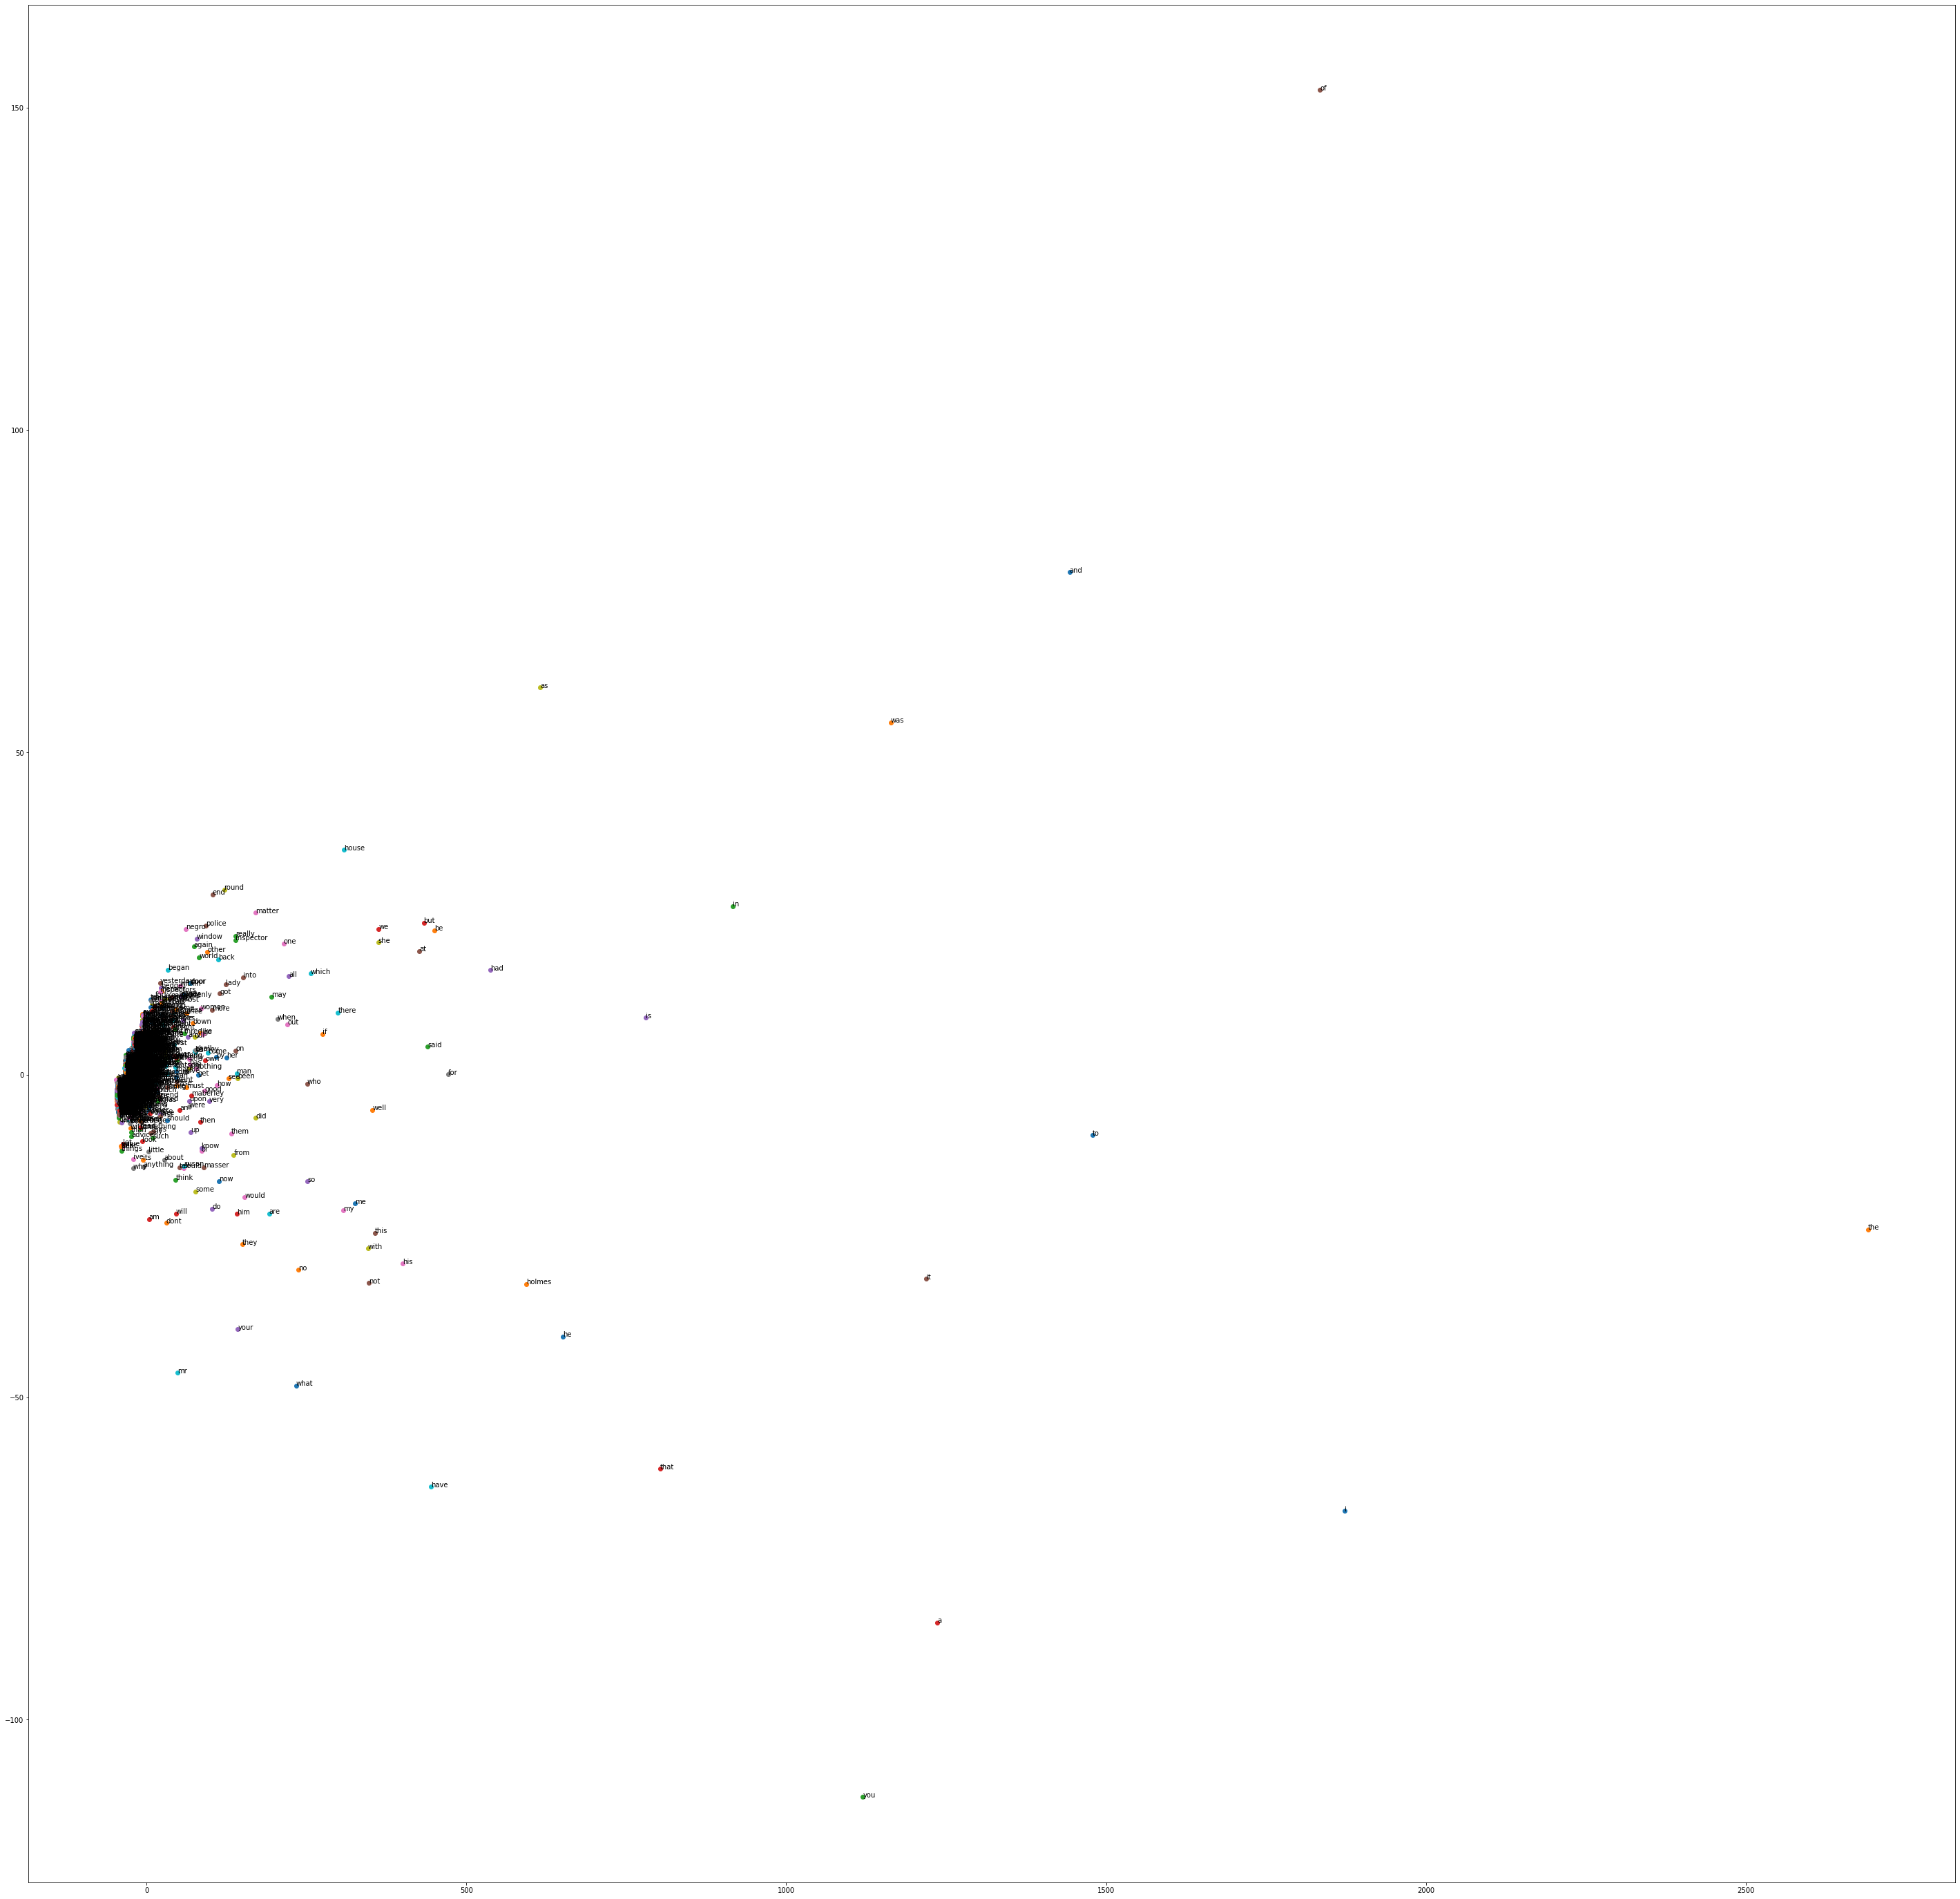

In [ ]:
plt.figure(figsize = (50, 50))
for word, vector in word_to_reduce_vector.items():
  plt.scatter(vector[0], vector[1])
  plt.annotate(word, (vector[0], vector[1]))
plt.show() 